In [1]:
%matplotlib inline

import pymc3 as pm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
from datetime import  datetime
import scipy as stats
import sklearn

import seaborn as sns

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

os.chdir("C:\\Users\Alexandre\Desktop\Baysian_Reg")


In [2]:
df_order = pd.read_csv('order_items.csv')
print('Table df_order has dimensions of ' + str(df_order.shape))
print(df_order.head())

df_trips = pd.read_csv('train_trips.csv')
df_trips['shopping_started_at'] = pd.to_datetime(df_trips['shopping_started_at'])
df_trips['shopping_ended_at'] = pd.to_datetime(df_trips['shopping_ended_at'])
df_trips['shopping_length'] = df_trips['shopping_ended_at'] - df_trips['shopping_started_at']
df_trips['shopping_length_sec'] = df_trips['shopping_length'] / np.timedelta64(1, 's')
df_trips['shopping_length_min'] = df_trips['shopping_length_sec'] /  60.0

print('Table df_trips has dimensions of ' + str(df_trips.shape))
print(df_trips.head())
print(df_trips.dtypes)

Table df_order has dimensions of (2040286, 4)
   trip_id  item_id department_name  quantity
0  3119513   368671         Produce      10.0
1  3120462   368671         Produce      10.0
2  3120473   368671         Produce      10.0
3  3121910   368671         Produce       6.0
4  3122332   368671         Produce      10.0
Table df_trips has dimensions of (117063, 9)
   trip_id  shopper_id fulfillment_model  store_id shopping_started_at  \
0  3119519       48539           model_1         6 2015-09-01 07:03:56   
1  3119513        3775           model_1         1 2015-09-01 07:04:33   
2  3119516        4362           model_1         1 2015-09-01 07:23:21   
3  3119792       47659           model_1         1 2015-09-01 07:29:52   
4  3119922       11475           model_1         1 2015-09-01 07:32:21   

    shopping_ended_at shopping_length  shopping_length_sec  \
0 2015-09-01 07:30:56        00:27:00               1620.0   
1 2015-09-01 07:40:33        00:36:00               2160.0   
2 

In [3]:
df_order_group = df_order.groupby('trip_id')   
df_order_sum = pd.DataFrame({'item_id_count': df_order_group.item_id.count(),
                             'item_id_count_unique': df_order_group.item_id.nunique(),
                             'dep_name_count': df_order_group.department_name.count(),
                             'dep_name_count_unique': df_order_group.department_name.nunique(),
                             'quantity_sum': df_order_group.quantity.sum()
                                  })

print(df_order_sum.head())                 

         dep_name_count  dep_name_count_unique  item_id_count  \
trip_id                                                         
3119513              33                      8             33   
3119516               5                      5              5   
3119518              12                      6             12   
3119519              26                     11             26   
3119520              33                     14             33   

         item_id_count_unique  quantity_sum  
trip_id                                      
3119513                    33         183.0  
3119516                     5           9.0  
3119518                    12          21.0  
3119519                    26          39.0  
3119520                    33          36.0  


In [4]:
df_all = pd.merge(df_trips, df_order_sum, left_on='trip_id', right_index=True, how='left')
print('Table df_all has dimensions of ' + str(df_all.shape))
print(df_all.head())

Table df_all has dimensions of (117063, 14)
   trip_id  shopper_id fulfillment_model  store_id shopping_started_at  \
0  3119519       48539           model_1         6 2015-09-01 07:03:56   
1  3119513        3775           model_1         1 2015-09-01 07:04:33   
2  3119516        4362           model_1         1 2015-09-01 07:23:21   
3  3119792       47659           model_1         1 2015-09-01 07:29:52   
4  3119922       11475           model_1         1 2015-09-01 07:32:21   

    shopping_ended_at shopping_length  shopping_length_sec  \
0 2015-09-01 07:30:56        00:27:00               1620.0   
1 2015-09-01 07:40:33        00:36:00               2160.0   
2 2015-09-01 07:41:21        00:18:00               1080.0   
3 2015-09-01 08:55:52        01:26:00               5160.0   
4 2015-09-01 09:01:21        01:29:00               5340.0   

   shopping_length_min  dep_name_count  dep_name_count_unique  item_id_count  \
0                 27.0              26                    

In [5]:
df_shopper_group = df_all.groupby('shopper_id')   
df_shopper_mean = pd.DataFrame({'quantity_total': df_shopper_group.quantity_sum.sum(),
                             'shopping_length_min_total': df_shopper_group.shopping_length_min.sum()
                                  })

df_shopper_mean['Avg_Speed'] = df_shopper_mean['shopping_length_min_total'] / df_shopper_mean['quantity_total']
df_shopper_mean['Avg_Speed_Cap'] = np.minimum(5,df_shopper_mean['Avg_Speed'])
df_shopper_mean['Avg_Speed_Cap'] = df_shopper_mean['Avg_Speed_Cap'].round(decimals=2)
df_shopper_mean = df_shopper_mean[['Avg_Speed_Cap']]
print(df_shopper_mean.head())

df_all_2 = pd.merge(df_all, df_shopper_mean, left_on='shopper_id', right_index=True, how='left')

print(df_all_2.head())

            Avg_Speed_Cap
shopper_id               
52                   1.27
64                   3.35
89                   1.38
95                   0.75
100                  1.27
   trip_id  shopper_id fulfillment_model  store_id shopping_started_at  \
0  3119519       48539           model_1         6 2015-09-01 07:03:56   
1  3119513        3775           model_1         1 2015-09-01 07:04:33   
2  3119516        4362           model_1         1 2015-09-01 07:23:21   
3  3119792       47659           model_1         1 2015-09-01 07:29:52   
4  3119922       11475           model_1         1 2015-09-01 07:32:21   

    shopping_ended_at shopping_length  shopping_length_sec  \
0 2015-09-01 07:30:56        00:27:00               1620.0   
1 2015-09-01 07:40:33        00:36:00               2160.0   
2 2015-09-01 07:41:21        00:18:00               1080.0   
3 2015-09-01 08:55:52        01:26:00               5160.0   
4 2015-09-01 09:01:21        01:29:00               5340.0   



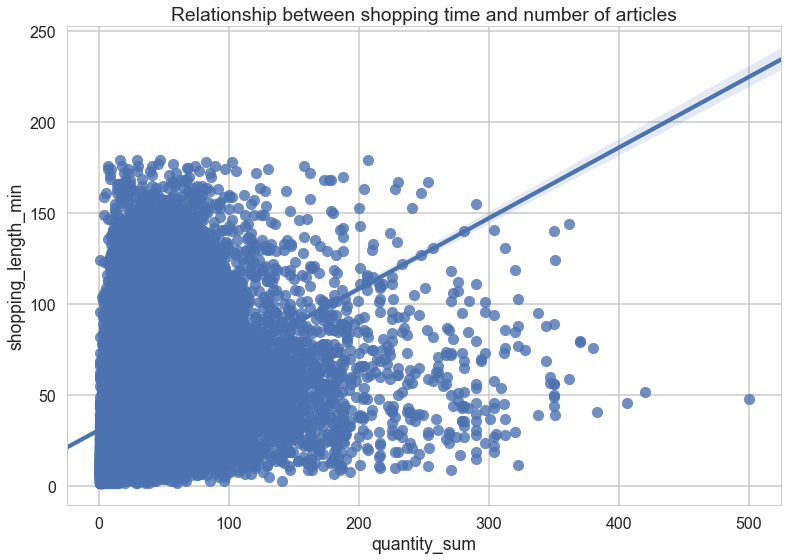

In [6]:
sns.regplot(y="shopping_length_min", x="quantity_sum", data=df_all_2, fit_reg = True)
plt.title("Relationship between shopping time and number of articles")

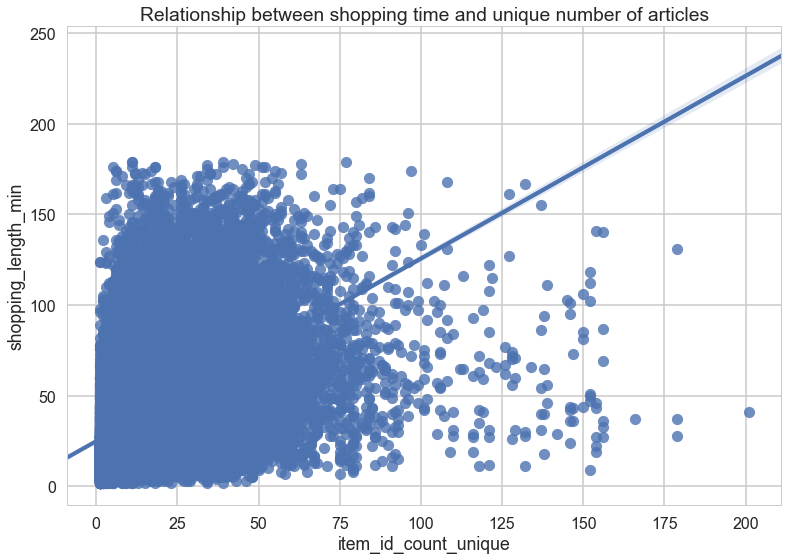

In [7]:
sns.regplot(y="shopping_length_min", x="item_id_count_unique", data=df_all_2, fit_reg = True)
plt.title("Relationship between shopping time and unique number of articles")

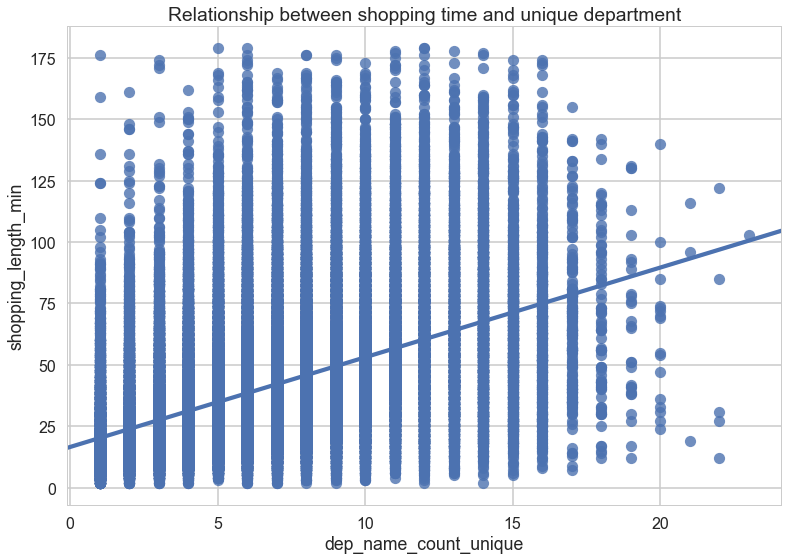

In [8]:
sns.regplot(y="shopping_length_min", x="dep_name_count_unique", data=df_all_2, fit_reg = True)
plt.title("Relationship between shopping time and unique department")

In [9]:
x1 = df_all_2['Avg_Speed_Cap']
x2 = df_all_2['quantity_sum']
y = df_all_2['shopping_length_min']
data = dict(x1=x1, x2=x2, y=y)

In [ ]:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff1 = pm.Normal('xc1', 0, sd=20)
    x_coeff2 = pm.Normal('xc2', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff1 * x1 + x_coeff2 * x2,
                        sd=sigma, observed=y)
    
    trace = pm.sample(2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 5.4573e+05:   8%|▊         | 16765/200000 [00:44<07:24, 412.14it/s]
Convergence archived at 16800
Interrupted at 16,800 [8%]: Average Loss = 3.7033e+07


In [ ]:
with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x1 + x2', data)
    trace = pm.sample(3000, njobs=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 5.4688e+05:   8%|▊         | 16188/200000 [01:01<10:31, 291.10it/s]
Convergence archived at 16200
Interrupted at 16,200 [8%]: Average Loss = 3.2397e+07
